# Exploring my dataset using clustering - affinity propagation

production: `/heroku/clustering.py`

http://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#example-cluster-plot-affinity-propagation-py

In [1]:
import numpy as np
import pandas as pd
import psycopg2

In [32]:
conn = psycopg2.connect("dbname='indicators'")
cursor = conn.cursor()
query = """SELECT country, indicator, zscore from indicators;"""
cursor.execute(query)
df0 = pd.DataFrame(cursor.fetchall(),
		  columns=[desc[0] for desc in cursor.description])

In [33]:
# select indicators: random or specified
selected = df0['indicator'].sample(5)
selected = ['ST.INT.ARVL', 'GCI.A.01', 'GCI.B.06', 'GCI.B.08', 'SP.POP.GROW']
selected

['ST.INT.ARVL', 'GCI.A.01', 'GCI.B.06', 'GCI.B.08', 'SP.POP.GROW']

In [37]:
df = (df0[(df0.indicator.isin(selected))]
      .pivot(index='country', columns = 'indicator', values='zscore'))
df.fillna(0, inplace=True)
query = """SELECT indicator, label_short from metadata"""
cursor.execute(query)
indicator_labels = pd.DataFrame(cursor.fetchall(),
				columns=[desc[0] for desc in cursor.description])
i_labs = indicator_labels[(indicator_labels.indicator.isin(selected))]
conn.close()

In [154]:
print df.head()
print "\nIndicators"
print i_labs

indicator       GCI.A.01  GCI.B.06  GCI.B.08  SP.POP.GROW  ST.INT.ARVL
country                                                               
Afghanistan     0.000000  0.000000  0.000000     1.394280     0.000000
Albania        -0.687855 -0.345454 -0.792408    -1.135210    -0.220841
Algeria        -0.659362 -1.551330 -1.639340     0.511848    -0.239885
American Samoa  0.000000  0.000000  0.000000    -0.862155    -0.462991
Andorra         0.000000  0.000000  0.000000    -4.438730    -0.265421

Indicators
      indicator                                    label_short
11  SP.POP.GROW                              Population growth
13  ST.INT.ARVL      International tourism, number of arrivals
14     GCI.A.01                  Competitiveness, Institutions
19     GCI.B.06       Competitiveness, Goods market efficiency
21     GCI.B.08  Competitiveness, Financial market development


# CLUSTER them with Affinity Propagation

In [40]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [72]:
X = np.array(df)
labels_true = df.index

In [73]:
print X[:4]
print labels_true

[[ 0.        0.        0.        1.39428   0.      ]
 [-0.687855 -0.345454 -0.792408 -1.13521  -0.220841]
 [-0.659362 -1.55133  -1.63934   0.511848 -0.239885]
 [ 0.        0.        0.       -0.862155 -0.462991]]
Index([u'Afghanistan', u'Albania', u'Algeria', u'American Samoa', u'Andorra',
       u'Angola', u'Antigua and Barbuda', u'Argentina', u'Armenia', u'Aruba',
       ...
       u'Uruguay', u'Uzbekistan', u'Vanuatu', u'Venezuela', u'Vietnam',
       u'Virgin Islands', u'West Bank and Gaza', u'Yemen', u'Zambia',
       u'Zimbabwe'],
      dtype='object', name=u'country', length=219)


In [43]:
af = AffinityPropagation().fit(X)

In [44]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_		# the clustering labels: 0 to n_clusters_
n_clusters_ = len(cluster_centers_indices)

In [96]:
cluster_centers_indices

array([  1,   4,   9,  12,  17,  32,  41,  44,  75,  79,  82, 122, 145,
       176, 182, 186, 200, 205, 207, 208])

In [95]:
# labels = the clustering labels
print n_clusters_, "= Number of clusters"
print max(labels)+1, "= Max cluster label value"
print labels[:10], " = first x labels"

20 = Number of clusters
20 = Max cluster label value
[ 7  0  9  2  1  9  2 10  2  2]  = first x labels


In [45]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Homogeneity: %0.3f' % metrics.homogeneity_score(labels_true, labels))
print('Completeness: %0.3f' % metrics.completeness_score(labels_true, labels))
print('V-measure: %0.3f' % metrics.v_measure_score(labels_true, labels))
print('Adjusted Rand Index: %0.3f' % metrics.adjusted_rand_score(
    labels_true, labels))
print('Adjusted Mutual Information %0.3f' %
      metrics.adjusted_mutual_info_score(labels_true, labels))
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(
    X, labels, metric='sqeuclidean'))

Estimated number of clusters: 20
Homogeneity: 0.490
Completeness: 1.000
V-measure: 0.658
Adjusted Rand Index: 0.000
Adjusted Mutual Information 0.000
Silhouette Coefficient: 0.385


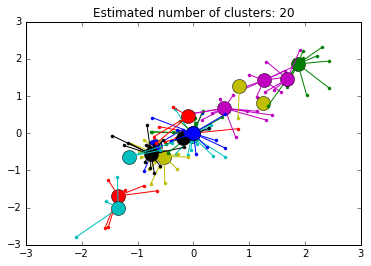

In [46]:
import matplotlib.pyplot as plt
from itertools import cycle
%matplotlib inline

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)    

In [67]:
# print members of a cluster (from 0 to 20)
k = 0
class_members=(labels==k)
print "Selected indicators:"
#print selected.values
print selected
print "\nIndicator labels:"
print i_labs
print "\nCluster members (k = %i):" % k
print labels_true[class_members]

Selected indicators:
['ST.INT.ARVL', 'GCI.A.01', 'GCI.B.06', 'GCI.B.08', 'SP.POP.GROW']

Indicator labels:
      indicator                                    label_short
11  SP.POP.GROW                              Population growth
13  ST.INT.ARVL      International tourism, number of arrivals
14     GCI.A.01                  Competitiveness, Institutions
19     GCI.B.06       Competitiveness, Goods market efficiency
21     GCI.B.08  Competitiveness, Financial market development

Cluster members (k = 0):
Index([u'Albania', u'Moldova', u'Serbia', u'Slovenia'], dtype='object', name=u'country')


In [68]:
print class_members
print sum(class_members)
print labels

[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  T

In [78]:
cluster_centers_indices

array([  6,   8,  25,  28,  41,  57,  75,  98, 102, 105, 107, 117, 136,
       139, 140, 141, 144, 172, 173, 186, 193])

In [102]:
print len(labels_true)
print labels_true

219
Index([u'Afghanistan', u'Albania', u'Algeria', u'American Samoa', u'Andorra',
       u'Angola', u'Antigua and Barbuda', u'Argentina', u'Armenia', u'Aruba',
       ...
       u'Uruguay', u'Uzbekistan', u'Vanuatu', u'Venezuela', u'Vietnam',
       u'Virgin Islands', u'West Bank and Gaza', u'Yemen', u'Zambia',
       u'Zimbabwe'],
      dtype='object', name=u'country', length=219)


## Explore label filter

In [117]:
label_map = pd.DataFrame({"label": labels,
		     "country": labels_true}).sort_values(["label", "country"])
label_map.head(12)

                 country  label
1                Albania      0
128              Moldova      0
164               Serbia      0
170             Slovenia      0
4                Andorra      1
3         American Samoa      2
6    Antigua and Barbuda      2
8                Armenia      2
9                  Aruba      2
16               Belarus      2
20               Bermuda      2
38       Channel Islands      2

In [158]:
_country = "France"
cluster = label_map[label_map.country.isin([_country])].label

In [166]:
similar_countries = label_map[label_map.label.isin(cluster)].country.tolist()
print [x for x in similar_countries if x != _country]

['United States']


In [163]:
_country

'France'

In [149]:
y

['American Samoa',
 'Antigua and Barbuda',
 'Armenia',
 'Aruba',
 'Belarus',
 'Bermuda',
 'Channel Islands',
 'Cuba',
 "Dem. People's Rep. Korea",
 'Dominica',
 'El Salvador',
 'Fiji',
 'Georgia',
 'Grenada',
 'Guyana',
 'Isle of Man',
 'Jamaica',
 'Kosovo',
 'Liechtenstein',
 'Marshall Islands',
 'Micronesia',
 'Monaco',
 'Montenegro',
 'Palau',
 'Samoa',
 'San Marino',
 'St. Lucia',
 'St. Martin (French part)',
 'St. Vincent and the Grenadines',
 'Tonga',
 'Tuvalu',
 'Uruguay']